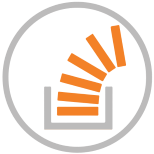

# Catégorisez automatiquement des questions - Exploration

### Sommaire


* [1. Importation des librairies, définition des fonctions et importation du fichier](#1)
    * [1.1 Importation des librairies](#1_1)
    * [1.2 Fonctions](#1_2)
    * [1.3 Importation du fichier](#1_3)
* [2. Analyse des données numériques](#2)
    * [2.1 Nombre de questions en fonction de la date](#2_1)
    * [2.2 Nombre de réponses en fonction de la date](#2_2)
    * [2.3 Nombre de vues en fonction de la date](#2_3)
* [3. Analyse des données textuelles](#3)
    * [3.1 Les titres](#3_1)
    * [3.2 Les questions](#3_2)
    * [3.3 Les tags](#3_3)
* [4. Analyse des corrélations](#4)
* [5. Analyse des corpus](#5)
    * [5.1 Pour les titres et les questions](#5_1)
        * [5.1.1 Nettoyage des balises et suppression du code dans les questions](#5_1_1)
        * [5.1.2 Travailler sur l'ensemble du corpus](#5_1_2)
    * [5.2 Pour les tags](#5_2)
* [6. Nettoyage des documents ](#6)
    * [6.1 Nettoyage de Title_Body](#6_1)
    * [6.2 Nettoyage des Tags](#6_2)
* [7. Analyse après nettoyage](#7)
    * [7.1 Pour clean_title_body](#7_1)
    * [7.2 Pour clean_tags](#7_2)
* [8. Export du DataFrame nettoyé](#8)
* [9. Enregistrement des listes pour l'API](#9)

## 1. Importation des librairies, définition des fonctions et importation du fichier <a class="anchor" id="1"></a>

### 1.1 Importation des librairies <a class="anchor" id="1_1"></a>

In [1]:
# Data
import pandas as pd
import numpy as np

# Graphiques
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLTK
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer

# Balises HTML
from bs4 import BeautifulSoup
import re

# Pour améliorer les performances (parallélisme)
import mapply

# Enregistrement
import pickle

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Initialisation de mapply
mapply.init(
    n_workers=-1,
    chunk_size=100,
    max_chunks_per_worker=8,
    progressbar=True
)

### 1.2 Fonctions <a class="anchor" id="1_2"></a>

In [3]:
def clean_text(html_text):
    """Fonction pour supprimer les balises HTML de chaque document
    et supprimer le code copié par les utilisateurs"""

    # Supprimer le contenu entre les balises <code>
    texte_sans_code = re.sub(r'<code>(.*?)</code>', ' ', html_text, flags=re.DOTALL)

    # Supprimer les balises HTML
    soup = BeautifulSoup(texte_sans_code, 'html.parser')
    texte_sans_balises = soup.get_text(separator=' ', strip=True)

    return texte_sans_balises

def display_tokens_info(tokens):
    """Nombre de tokens et nombre de tokens uniques"""

    print(f"nb tokens {len(tokens)}, nb tokens unique {len(set(tokens))}")
    print(tokens[:30])

def process_text(doc,
                 rejoin = False,
                 lemm_or_stemm = 'stem',
                 technical_terms = None,
                 words_to_remove = None,
                 min_len_word = None,
                 force_is_alpha = True,
                 eng_words = None):
    """Fonction de text processing
    Arguments obligatoires :
    ---------------------------
    doc : str : le document (un texte au format str)

    Arguments optionnels :
    ---------------------------
    rejoin : bool : si vrai retourne une string sinon retourne un liste de tokens
    lemm_or_stemm : str : si lem faire un lemmentize sinon un stemmentize
    technical_terms : list : une liste de mots techniques qui ne doivent pas être supprimés
    words_to_remove : list : une liste de mots à exclure
    min_len_word : int : le minimum d'occurrence des mots à garder dans le corpus
    force_is_alpha : int : si 1, tout les tokens avec des caractères numériques sont exclus
    eng_words : list : liste de mots anglais à garder

    return :
    ---------------------------
    une string (si rejoin est à True) ou une liste de tokens"""

    import re
    import nltk
    from nltk.stem import PorterStemmer, WordNetLemmatizer
    from nltk.tokenize import word_tokenize, RegexpTokenizer
    from nltk.corpus import stopwords

    # Liste des rares words
    words_to_remove = words_to_remove or []

    # Mettre en minuscule
    doc = doc.lower().strip()

    # Tokenization personnalisée
    if technical_terms is None:
        technical_terms = []

    # Créer une expression régulière en utilisant les termes techniques
    technical_terms_pattern = "|".join(re.escape(term) for term in technical_terms)

    # Ajouter \w+ pour capturer les autres mots
    regexp = r"{}|\w+".format(technical_terms_pattern)
    tokens = re.findall(regexp, doc)

    # stop words
    stop_words = set(stopwords.words('english'))
    cleaned_tokens_list = [w for w in tokens if w not in stop_words]

    # words to remove
    cleaned_tokens_final = [w for w in cleaned_tokens_list if w not in words_to_remove]

    # No more len words
    if min_len_word is None:
        more_than_N = cleaned_tokens_final
    else:
        more_than_N = [w for w in cleaned_tokens_final if len(w) >= min_len_word]
    
    # Exclure les tokens composés uniquement de chiffres si force_is_alpha est True
    if force_is_alpha:
        alpha_tokens = [w for w in more_than_N if not w.isdigit()]

    # Stem ou lem
    trans = WordNetLemmatizer() if lemm_or_stemm == 'lem' else PorterStemmer()
    trans_text = [trans.lemmatize(i) if lemm_or_stemm == 'lem' else trans.stem(i) for i in alpha_tokens]

    # Filtrer les mots anglais si nécessaire
    engl_text = [i for i in trans_text if not eng_words or i in eng_words]

    if rejoin:
        return " ".join(engl_text)

    return engl_text

### 1.3 Importation du fichier <a class="anchor" id="1_3"></a>

Nous avons exporté les données essentielles pour travailler sur la problématique de proposition de tags automatiques à la communauté de StackOverflow, pour cela, nous avons utilisé StackExchange Data Explorer et avons extrait un fichier CSV grâce à la requête SQL suivante :

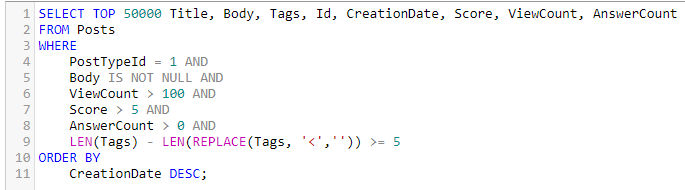

In [4]:
df_questions = pd.read_csv('QueryResults.csv')
df_questions.set_index('Id', inplace=True)
df_questions.head()

,Title,Body,Tags,CreationDate,Score,ViewCount,AnswerCount
Id,,,,,,,
77574918,Is there a good reason to split in two differe...,<p>When reading through the OpenJDK code for c...,<java><arraylist><reflection><constructor><jav...,2023-11-29 22:55:45,7,108,2
77564335,Problem loading external scripts like jQuery,<p>I'm facing a problem since this morning wit...,<javascript><html><jquery><google-apps-script>...,2023-11-28 13:37:38,14,1956,3
77556444,Null checking with primary constructor in C# 12,<p>I using C# 12.\nIn C# 12 I can use primary ...,<c#><.net-8.0><fail-fast><c#-12.0><primary-con...,2023-11-27 11:13:58,14,836,2
77551316,Does a const char* literal string persistently...,<p>I have functions like the following:</p>\n<...,<c++><constants><constexpr><lifetime><null-ter...,2023-11-26 10:42:31,10,915,4
77544923,Aggregate column with list of string with inte...,<p>I'm trying to aggregate some rows in my dat...,<python><dataframe><list><aggregation><python-...,2023-11-24 17:59:42,6,199,3


In [5]:
# Visualisation des données
df_questions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 77574918 to 45026159
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         50000 non-null  object
 1   Body          50000 non-null  object
 2   Tags          50000 non-null  object
 3   CreationDate  50000 non-null  object
 4   Score         50000 non-null  int64 
 5   ViewCount     50000 non-null  int64 
 6   AnswerCount   50000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 3.1+ MB


Aucune donnée manquante, nous pouvons continuer.

## 2. Analyse des données numériques <a class="anchor" id="2"></a>

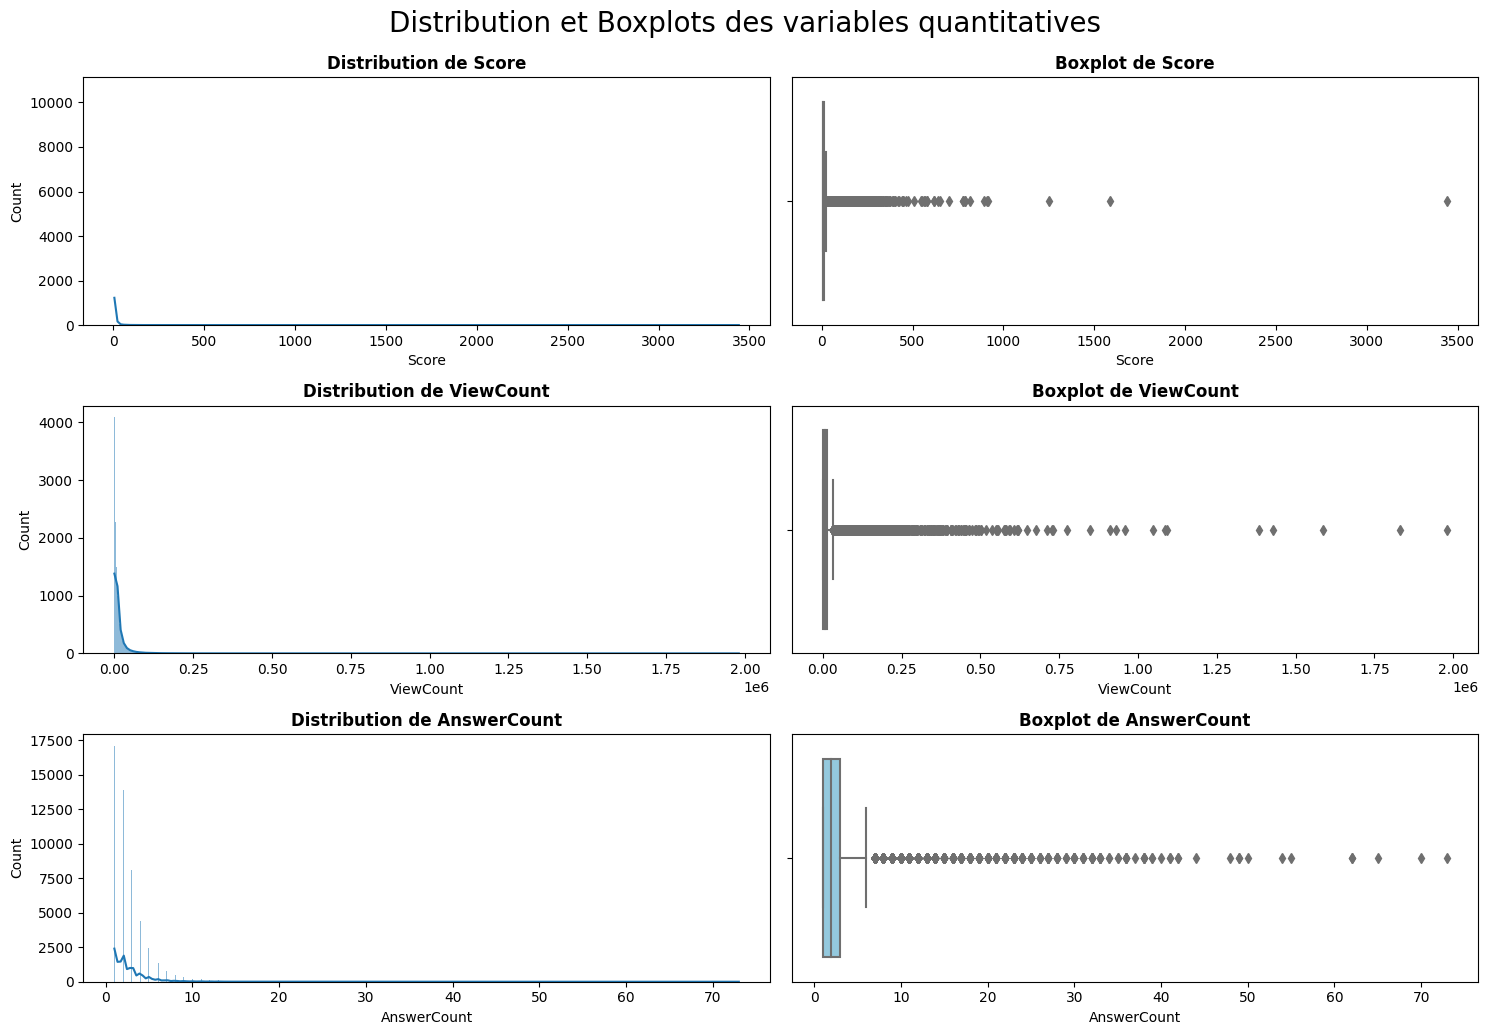

In [6]:
# Sélectionnons les variables quantitatives
variables_quantitatives = df_questions.select_dtypes(include=['int64'])

# Afficher la distribution de chaque variable quantitative avec un boxplot
plt.figure(figsize=(15, 10))

# Histogrammes
for i, colonne in enumerate(variables_quantitatives.columns):
    plt.subplot(3, 2, i * 2 + 1)
    sns.histplot(df_questions[colonne], kde=True, edgecolor='none')
    plt.title(f'Distribution de {colonne}', fontweight='bold')

# Boxplots
for i, colonne in enumerate(variables_quantitatives.columns):
    plt.subplot(3, 2, i * 2 + 2)
    sns.boxplot(x=df_questions[colonne], color='skyblue')
    plt.title(f'Boxplot de {colonne}', fontweight='bold')

plt.tight_layout()
plt.suptitle('Distribution et Boxplots des variables quantitatives', fontsize=20, y=1.03)
plt.show()

### 2.1 Nombre de questions en fonction de la date <a class="anchor" id="2_1"></a>

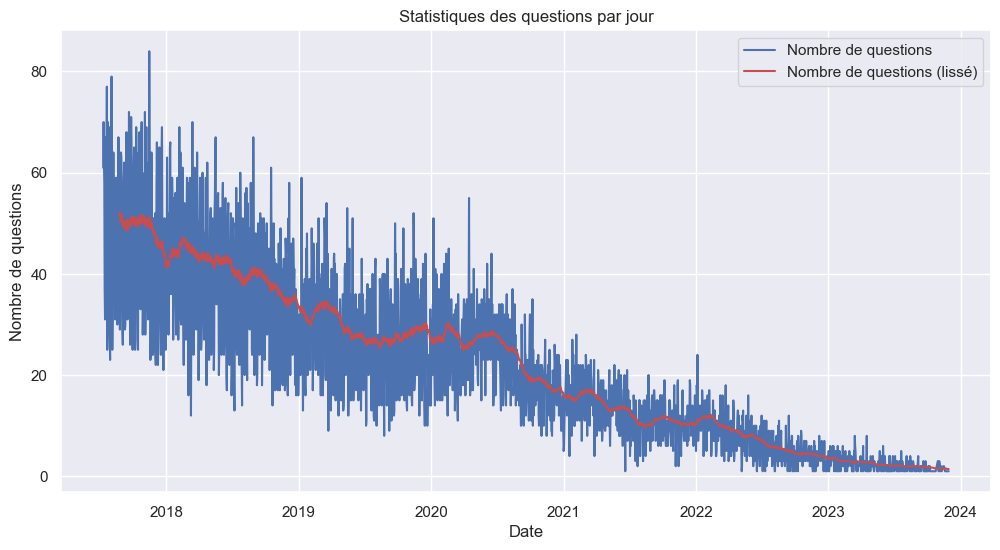

In [7]:
# Mettre les dates au format date
df_questions['CreationDate'] = pd.to_datetime(df_questions['CreationDate'])
df_questions['CreationDate'] = df_questions['CreationDate'].dt.date

# Classer par date
df_questions = df_questions.sort_values(by='CreationDate')

# Compter le nombre de questions/ réponses/ View par jours
df_counts = df_questions.groupby('CreationDate').agg({'Title': 'count', 
                                                      'AnswerCount': 'sum', 
                                                      'ViewCount': 'sum'}).reset_index()

# Renommer les colonnes pour plus de clarté
df_counts.columns = ['Date', 'Questions', 'Réponses', 'Vues']

# Calculer la moyenne mobile sur la colonne du nombre de questions
window_size = 45
df_counts['Questions_smoothed'] = df_counts['Questions'].rolling(window=window_size).mean()

# Créer un graphique avec Seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Questions', data=df_counts, label='Nombre de questions')
sns.lineplot(x='Date', y='Questions_smoothed', data=df_counts, label='Nombre de questions (lissé)', color='r')
plt.title('Statistiques des questions par jour')
plt.xlabel('Date')
plt.ylabel('Nombre de questions')
plt.legend()
plt.show()

### 2.2 Nombre de réponses en fonction de la date <a class="anchor" id="2_2"></a>

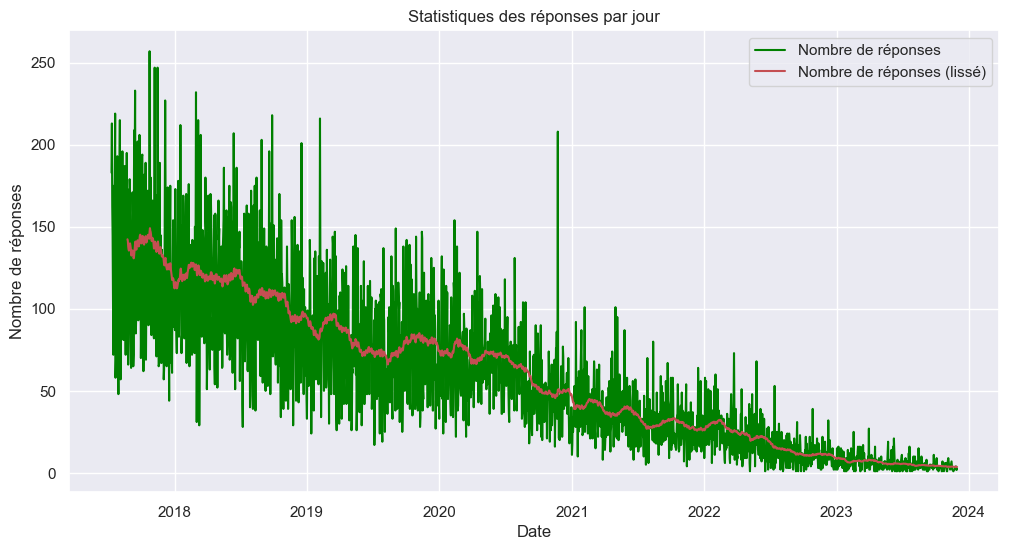

In [8]:
# Calculer la moyenne mobile sur la colonne du nombre de questions
window_size = 45
df_counts['Réponses_smoothed'] = df_counts['Réponses'].rolling(window=window_size).mean()

# Créer un graphique avec Seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Réponses', data=df_counts, label='Nombre de réponses', color='green')
sns.lineplot(x='Date', y='Réponses_smoothed', data=df_counts, label='Nombre de réponses (lissé)', color='r')
plt.title('Statistiques des réponses par jour')
plt.xlabel('Date')
plt.ylabel('Nombre de réponses')
plt.legend()
plt.show()

### 2.3 Nombre de vues en fonction de la date <a class="anchor" id="2_3"></a>

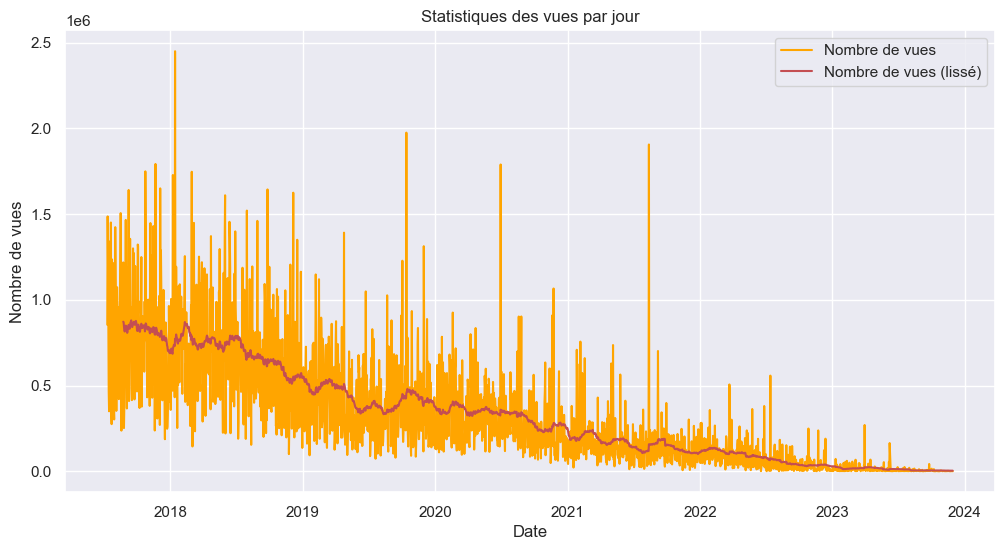

In [9]:
# Calculer la moyenne mobile sur la colonne du nombre de questions
window_size = 45
df_counts['Vues_smoothed'] = df_counts['Vues'].rolling(window=window_size).mean()

# Créer un graphique avec Seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Vues', data=df_counts, label='Nombre de vues', color='orange')
sns.lineplot(x='Date', y='Vues_smoothed', data=df_counts, label='Nombre de vues (lissé)', color='r')
plt.title('Statistiques des vues par jour')
plt.xlabel('Date')
plt.ylabel('Nombre de vues')
plt.legend()
plt.show()

## 3. Analyse des données textuelles <a class="anchor" id="3"></a>

### 3.1 Les titres <a class="anchor" id="3_1"></a>

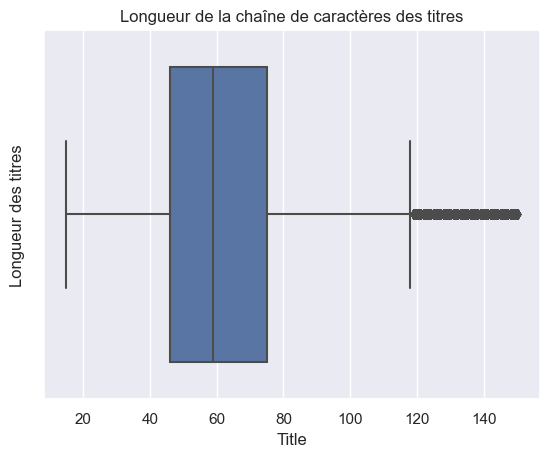

In [10]:
# Calculer la longueur des questions
len_titres = df_questions['Title'].str.len()

# Rajouter un colonne dans le DataFrame
df_questions['_len_Title'] = len_titres

# Afficher cela sur un graphique
plt.figure()
sns.boxplot(x=len_titres)
plt.title('Longueur de la chaîne de caractères des titres')
plt.ylabel('Longueur des titres')
plt.show()

### 3.2 Les questions <a class="anchor" id="3_2"></a>

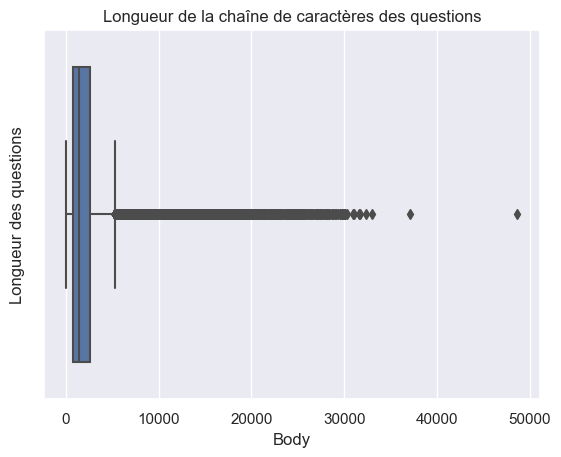

In [11]:
# Calculer la longueur des questions
len_questions = df_questions['Body'].str.len()

# Rajouter un colonne dans le DataFrame
df_questions['_len_Questions'] = len_questions

# Afficher cela sur un graphique
plt.figure()
sns.boxplot(x=len_questions)
plt.title('Longueur de la chaîne de caractères des questions')
plt.ylabel('Longueur des questions')
plt.show()

### 3.3 Les tags <a class="anchor" id="3_3"></a>

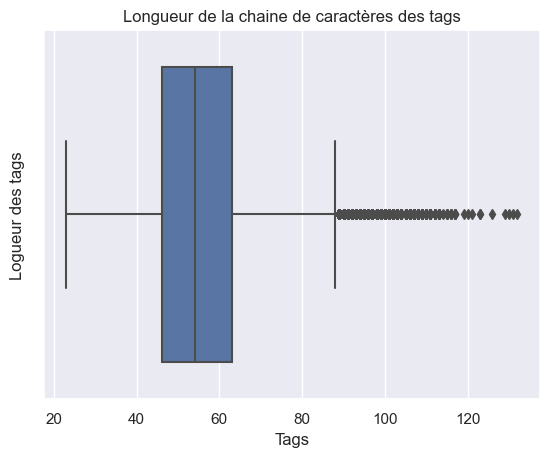

In [12]:
# Calculer la longeur des questions
len_tags = df_questions['Tags'].str.len()

# Rajouter un colonne dans le DataFrame
df_questions['_len_Tags'] = len_tags

# Affichons cela sur un graphique
plt.figure()
sns.boxplot(x=len_tags)
plt.title('Longueur de la chaine de caractères des tags')
plt.ylabel('Logueur des tags')
plt.show()

## 4. Analyse des corrélations <a class="anchor" id="4"></a>

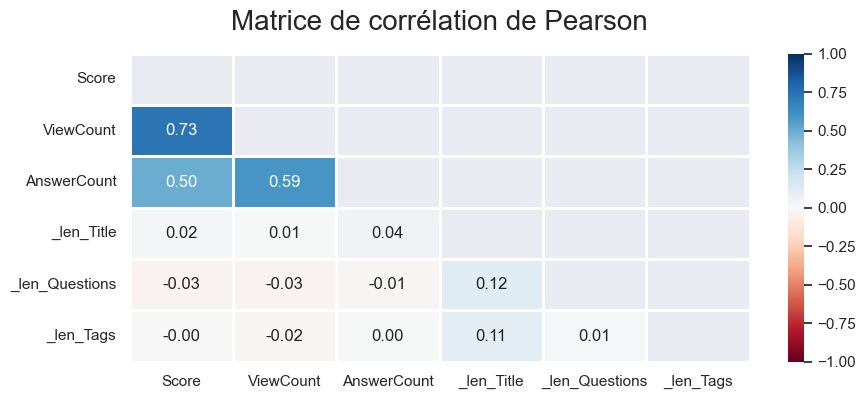

In [13]:
# Sélectionner seulement les variables quantitatives
variables_quantitatives = df_questions.select_dtypes(include=['float64', 'int64'])

# Matrice de corrélation de Pearson
mask = np.triu(np.ones_like(variables_quantitatives.corr(), dtype=bool)) 
plt.figure(figsize=(10, 4))
sns.heatmap(
    variables_quantitatives.corr(), 
    mask=mask, 
    center=0, 
    cmap='RdBu', 
    linewidths=1, 
    annot=True, 
    fmt='.2f', 
    vmin=-1, 
    vmax=1
)
plt.title('Matrice de corrélation de Pearson', fontsize=20, y=1.05)
plt.show()

## 5. Analyse des corpus <a class="anchor" id="5"></a>

In [14]:
# Concatener les titres et les questions
df_questions['Title_Body'] = df_questions['Title'].astype(str) + ' ' + df_questions['Body'].astype(str)

### 5.1 Pour les titres et les questions <a class="anchor" id="5_1"></a>

In [15]:
# Afficher directement les titres et les questions pour les 10 premières lignes
df_samp = df_questions.sample(10)

# Regardons de quoi est composé le corpus de ces 10 premières lignes
for idx, ser in df_samp.iterrows():
    print(ser['Title_Body']+ '...' + '\n\n')

What does the annotation @template mean in PHP doc blocks? <p>I could see this PHPDoc block in the <a href="https://github.com/FakerPHP/Faker" rel="noreferrer">FakerPHP/Faker</a> package, and I'm not aware what does <code>@template</code> mean? you can find it in the package's main branch on this <a href="https://github.com/FakerPHP/Faker/blob/main/src/Faker/Generator.php#L574" rel="noreferrer">line</a></p>
<pre class="lang-php prettyprint-override"><code>/**
 * @template T of Extension\Extension
 *
 * @param class-string&lt;T&gt; $id
 *
 * @throws ContainerExceptionInterface
 * @throws Extension\ExtensionNotFound
 *
 * @return T
 */
</code></pre>
...


In what order does Python find syntax errors? <p>Working on creating syntax debugging exercise for students. We have the following example.</p>
<pre><code>def five():
    print('five')
return 5

def hello();
   print('hello')
</code></pre>
<p>However when running the file the syntax error is</p>
<pre><code>def hello();
           ^
Synt

La première chose est que l'on a des balises HTML dans l'export des questions.

On va donc les enlever et également supprimer le code que les utilisateurs on copier dans leurs questions car celui-ci ne nous sera pas vraiment utile.

#### 5.1.1 Nettoyage des balises et suppression du code dans les questions <a class="anchor" id="5_1_1"></a>

In [16]:
# Enlever les balises HTML et supprimer les morceaux de codes des questions
for idx, ser in df_questions.iterrows():
    corpus_clean = clean_text(ser['Title_Body'])
    df_questions.at[idx, 'Title_Body'] = corpus_clean

#### 5.1.2 Travailler sur l'ensemble du corpus <a class="anchor" id="5_1_2"></a>

Joignons et regardons rapidement le corpus "brut".

In [17]:
# Joindre les documents entre eux
raw_corpus = "".join(df_questions['Title_Body'].values)
raw_corpus[:3_000]

'Data binding in adapter of recyclerView - Android I am using   in my project to populate a  . How can I handle clicks on items? Here is my XML layout: I specified the   handler in this line: And below is my adapter: However, the following code doesn\'t work:Detecting/Diagnosing Thread Starvation I am doing some performance/scalability testing of an IIS application that occasionally seems to slow down to a crawl in production.  I\'m able to reproduce the slowness consistently using NUnit. CPU and Memory do not spike during the testing, or when the slowness occurs in production.  My strong suspicion is that the application is suffering from thread starvation, since it does not appear to be CPU, Memory, I/O, or database access that is causing the bottleneck.  I do see signs of what appear to be thread starvation; for example, NLog\'s async log file writes tend to have long periods of silence followed by bursts of activity with older time stamps (i.e. a lower-priority thread is waiting fo

In [18]:
# Nombre de tokens sur le corpus "brut"
len(raw_corpus)

39269714

Tokenisons le corpus afin de comprendre comment il est constitué.

Attention beaucoup de termes techniques, nous allons essayer de créer un liste qui permettrait de les identifier.

Demandons à ChatGPT de nous proposer une liste de terme technique que nous pourrions retrouver sur StackOverFlow, nous rajouterons certains termes au besoin sur cette liste de base. 

In [19]:
technical_terms = [
    '.net',
    'algorithm',
    'api',
    'artificialintelligence',
    'bigdata',
    'blockchain',
    'cloudcomputing',
    'cybersecurity',
    'c++',
    'c#',
    'ios',
    'datascience',
    'database',
    'deeplearning',
    'devops',
    'docker',
    'encryption',
    'framework',
    'frontend',
    'fullstack',
    'git',
    'graphql',
    'hadoop',
    'ide',
    'iot',
    'json',
    'kubernetes',
    'lambdafunction',
    'machinelearning',
    'microservices',
    'middleware',
    'mongodb',
    'neuralnetwork',
    'nodejs',
    'nlp',
    'nosql',
    'oauth',
    'orm',
    'paas',
    'php',
    'python',
    'react',
    'restfulapi',
    'saas',
    'scrum',
    'sql',
    'tensorflow',
    'uiuxdesign',
    'versioncontrol',
    'virtualization',
    'vuejs',
    'webdevelopment',
    'agile',
    'apigateway',
    'aws',
    'bash',
    'bootstrap',
    'cicd',
    'css',
    'd3js',
    'django',
    'elasticsearch',
    'flask',
    'gitlab',
    'hashfunction',
    'html',
    'http',
    'https',
    'jenkins',
    'jira',
    'kafka',
    'lambdaarchitecture',
    'linux',
    'mapreduce',
    'maven',
    'mvc',
    'mysql',
    'nginx',
    'openai',
    'oauth',
    'opensource',
    'orm',
    'postgresql',
    'puppet',
    'pytorch',
    'rabbitmq',
    'redux',
    'responsivedesign',
    'rpa',
    'ruby',
    'rust',
    'selenium',
    'shellscripting',
    'soap',
    'springframework',
    'sqlinjection',
    'ssl',
    'swagger',
    'terraform',
    'typescript',
    'ubuntu',
    'unittesting',
    'unix',
    'virtualmachine',
    'webassembly',
    'websockets',
    'xml',
    'yaml',
    'zookeeper',
    'abtesting',
    'aop',
    'awslambda',
    'backpropagation',
    'bayesiannetwork',
    'captheorem',
    'chaosengineering',
    'chatbot',
    'cicdpipeline',
    'cleancode',
    'clustering',
    'containerization',
    'continuousdeployment',
    'cronjob',
    'csrf',
    'daas',
    'ddos',
    'decisiontree',
    'dependencyinjection',
    'dockercompose',
    'dns',
    'etl',
    'featureengineering',
    'flaskrestful',
    'forwardproxy',
    'fuzzylogic',
    'geneticalgorithm',
    'graphqlschema',
    'hateoas',
    'helm',
    'hexagonalarchitecture',
    'hiddenmarkovmodel',
    'hyperledger',
    'inversionofcontrol',
    'jsonwebtoken',
    'kanban',
    'kmeansclustering',
    'lampstack',
    'loadbalancer',
    'logstash',
    'longpolling',
    'lucene',
    'memcached',
    'microfrontend',
    'microkernelarchitecture',
    'modelviewviewmodel',
    'multicloud',
    'multithreading',
    'naivebayes',
    'oauth2',
    'openshift',
    'pagerank',
    'pear',
    'performancetesting',
    'policygradient',
    'portforwarding',
    'principalcomponentanalysis',
    'progressivewebapp',
    'pubsub',
    'pythonpackageindex',
    'qlearning',
    'raid',
    'reactiveprogramming',
    'redblacktree',
    'reinforcementlearning',
    'resilience4j',
    'reverseproxy',
    'rnn',
    'roccurve',
    'rpc',
    'rulebasedsystem',
    's3',
    'saltstack',
    'scikitlearn',
    'serverlesscomputing',
    'servicemesh',
    'sigmoidfunction',
    'singletonpattern',
    'solidprinciples',
    'springboot',
    'springcloud',
    'springdatajpa',
    'springsecurity',
    'sqljoin',
    'ssis',
    'stochasticgradientdescent'
]

In [20]:
# Processing sur l'ensemble du corpus avec une lemmatisation
corpus = process_text(raw_corpus, lemm_or_stemm = 'lem', technical_terms = technical_terms)
display_tokens_info(corpus)

nb tokens 3620323, nb tokens unique 87167
['data', 'binding', 'adapter', 'recyclerview', 'android', 'using', 'project', 'populate', 'handle', 'click', 'item', 'xml', 'layout', 'specified', 'handler', 'line', 'adapter', 'however', 'following', 'code', 'work', 'detecting', 'diagnosing', 'thread', 'starvation', 'performance', 'scalability', 'testing', 'ii', 'application']


In [21]:
# Nombre de valeurs uniques
tmp = pd.Series(corpus).value_counts()

# Créer un DataFrame avec les résultats
df_tokens_corpus = pd.DataFrame({
    'Tokens': tmp.index,
    'Nombre': tmp.values
})

# Trier le DataFrame par longueur
df_tokens_corpus = df_tokens_corpus.sort_values(by='Nombre', ascending=False)

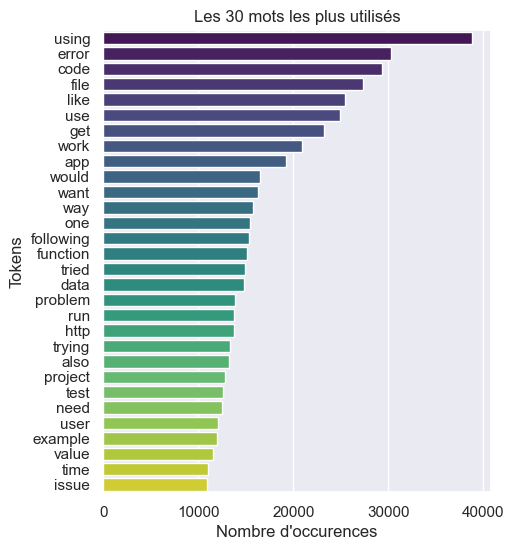

In [22]:
# Sélectionner les 30 premiers mots
top_30_tokens = df_tokens_corpus.head(30)

# Créer le diagramme en barres avec Seaborn
plt.figure(figsize=(5, 6))
sns.barplot(x='Nombre', y='Tokens', data=top_30_tokens, palette='viridis')
plt.xlabel("Nombre d'occurences")
plt.ylabel('Tokens')
plt.title('Les 30 mots les plus utilisés')
plt.show()

In [23]:
# Afficher un describe
df_tokens_corpus.describe()

,Nombre
count,87167.000000
mean,41.533183
std,464.885107
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,38857.000000


On va identifier les tokens les plus utilisés afin de pouvoir les supprimer sur l'ensemble du corpus.

Ces mots seront considérés comme étant des mots trop fréquents dans notre corpus et n'apportant pas de précisions afin de déduire le tags.

In [24]:
# Création de la liste des mots trop fréquents
common_words = tmp[tmp > 5000]
common_words = list(common_words.index)

# Nombre de mots
len(common_words)

112

In [25]:
common_words

['using',
 'error',
 'code',
 'file',
 'like',
 'use',
 'get',
 'work',
 'app',
 'would',
 'want',
 'way',
 'one',
 'following',
 'function',
 'tried',
 'data',
 'problem',
 'http',
 'run',
 'trying',
 'also',
 'project',
 'test',
 'need',
 'user',
 'example',
 'value',
 'time',
 'issue',
 'class',
 'application',
 'version',
 'type',
 'method',
 'api',
 'know',
 'question',
 'set',
 'server',
 'make',
 'see',
 'new',
 'python',
 'however',
 'working',
 'build',
 'image',
 'object',
 'j',
 'android',
 'java',
 'could',
 'com',
 'find',
 'request',
 'change',
 'create',
 'ide',
 'react',
 'help',
 'solution',
 'running',
 'used',
 'component',
 'result',
 'call',
 'package',
 'something',
 'found',
 'add',
 'first',
 'different',
 'page',
 'without',
 'service',
 'two',
 'update',
 'case',
 'library',
 'getting',
 'seems',
 'git',
 'still',
 'line',
 'look',
 '.net',
 'try',
 'module',
 'output',
 'able',
 'docker',
 'core',
 'json',
 'model',
 'command',
 'fine',
 'return',
 'message',

En actant sur le fait que 5000 occurences pour un token dans le corpus correspond à des mots trop communs, et en vérifiant la liste, on s'apperçoit que certains mots sont des mots importants pour la catégorisation des questions.

On va donc créer une liste pour garder ces mots importants et les enlever de la liste des common_words.

In [26]:
no_common_words = ['app', 'data', 'http', 'application', 'api', 'python', 'android', 'java',
                   'package', 'update', '.net', 'docker', 'core', 'json', 'model', 'command',
                   'window', 'google', 'io', 'list', 'access', 'variable', 'client', 'web']

common_words = [w for w in common_words if w not in no_common_words]

# Nombre de mots
len(common_words)

88

On va maintenant pouvoir identifier les tokens rares, donc on supprimera un token si il n'est utilisé qu'une seule fois sur l'ensemble du corpus.

In [27]:
# Création de la liste des mots présent 1 seule fois dans le corpus
list_unique_words = tmp[tmp == 1]
list_unique_words = list(list_unique_words.index)

# Nombre de mots
len(list_unique_words)

48301

In [28]:
# Enregistrer les tokens à supprimer dans une liste
words_to_remove = common_words + list_unique_words

# Nombre de mots
len(words_to_remove)

48389

On va également préparer une liste de mots anglais à laquelle on rajoutera les termes techniques, le but est de supprimer les mots qui n'en feraient pas partis.

In [29]:
# Nombre de mots dans words de nltk
len(set(words.words()))

235892

In [30]:
# Améliorer la liste des mots anglais dans nltk
eng_words = [i.lower() for i in words.words()]
display_tokens_info(eng_words)

nb tokens 236736, nb tokens unique 234377
['a', 'a', 'aa', 'aal', 'aalii', 'aam', 'aani', 'aardvark', 'aardwolf', 'aaron', 'aaronic', 'aaronical', 'aaronite', 'aaronitic', 'aaru', 'ab', 'aba', 'ababdeh', 'ababua', 'abac', 'abaca', 'abacate', 'abacay', 'abacinate', 'abacination', 'abaciscus', 'abacist', 'aback', 'abactinal', 'abactinally']


In [31]:
lm = WordNetLemmatizer()
eng_words_lem = [lm.lemmatize(i) for i in eng_words]
display_tokens_info(eng_words_lem)

nb tokens 236736, nb tokens unique 233450
['a', 'a', 'aa', 'aal', 'aalii', 'aam', 'aani', 'aardvark', 'aardwolf', 'aaron', 'aaronic', 'aaronical', 'aaronite', 'aaronitic', 'aaru', 'ab', 'aba', 'ababdeh', 'ababua', 'abac', 'abaca', 'abacate', 'abacay', 'abacinate', 'abacination', 'abaciscus', 'abacist', 'aback', 'abactinal', 'abactinally']


In [32]:
eng_words = [w for w in eng_words_lem if len(w) >= 2]

In [33]:
# On rajoute la liste des mots techniques
eng_words = eng_words + technical_terms
display_tokens_info(eng_words)

nb tokens 236870, nb tokens unique 233591
['aa', 'aal', 'aalii', 'aam', 'aani', 'aardvark', 'aardwolf', 'aaron', 'aaronic', 'aaronical', 'aaronite', 'aaronitic', 'aaru', 'ab', 'aba', 'ababdeh', 'ababua', 'abac', 'abaca', 'abacate', 'abacay', 'abacinate', 'abacination', 'abaciscus', 'abacist', 'aback', 'abactinal', 'abactinally', 'abaction', 'abactor']


### 5.2 Pour les tags <a class="anchor" id="5_2"></a>

In [34]:
# Joindre les documents entre eux
raw_corpus = "".join(df_questions['Tags'].values)
raw_corpus[:3_000]

'<android><data-binding><android-recyclerview><android-adapter><android-databinding><c#><.net><iis><threadpool><starvation><python><ssl><go><https><proxy><javascript><reactjs><charts><chart.js><chart.js2><java><floating-point><rust><microbenchmark><jmh><android><android-studio><junit><kotlin><spock><java><spring><websocket><spring-websocket><spring-webflux><javascript><node.js><mongodb><mongoose><aggregation-framework><c#><json><configuration><.net-core><.net-core-1.1><html><google-chrome><authentication><url><parameters><ios><xcode><storyboard><interface-builder><xcode9-beta><python><docker><scrapy><docker-compose><http-status-code-500><maven><intellij-idea><junit><junit4><junit5><assembly><optimization><x86><alignment><no-op><spring><spring-boot><spring-data-jpa><grpc><grpc-java><javascript><node.js><promise><callback><es6-promise><javascript><node.js><mongodb><database-design><mongoose><java><google-app-engine><java-8><publish-subscribe><google-cloud-pubsub><javascript><ios><reactjs

Ils sont séparés par des balises '<>' on va donc les supprimer.

In [35]:
raw_corpus =  re.sub(r'<([^>]+)>', r'\1 ', raw_corpus)
raw_corpus[:1_000]

'android data-binding android-recyclerview android-adapter android-databinding c# .net iis threadpool starvation python ssl go https proxy javascript reactjs charts chart.js chart.js2 java floating-point rust microbenchmark jmh android android-studio junit kotlin spock java spring websocket spring-websocket spring-webflux javascript node.js mongodb mongoose aggregation-framework c# json configuration .net-core .net-core-1.1 html google-chrome authentication url parameters ios xcode storyboard interface-builder xcode9-beta python docker scrapy docker-compose http-status-code-500 maven intellij-idea junit junit4 junit5 assembly optimization x86 alignment no-op spring spring-boot spring-data-jpa grpc grpc-java javascript node.js promise callback es6-promise javascript node.js mongodb database-design mongoose java google-app-engine java-8 publish-subscribe google-cloud-pubsub javascript ios reactjs react-native setstate html css odoo odoo-9 qweb python pandas dataframe boto3 pyarrow ios sw

In [36]:
# Nombre de tokens sur le corpus "brut" des tags
len(raw_corpus)

2538183

In [37]:
# Processing sur l'ensemble du corpus avec une lemmatisation
corpus = process_text(raw_corpus, lemm_or_stemm = 'lem', technical_terms = technical_terms)

# Suppression des tags à une seule lettre
corpus = [w for w in corpus if len(w) >= 2]
display_tokens_info(corpus)

nb tokens 344044, nb tokens unique 10603
['android', 'data', 'binding', 'android', 'recyclerview', 'android', 'adapter', 'android', 'databinding', 'c#', '.net', 'ii', 'threadpool', 'starvation', 'python', 'ssl', 'go', 'http', 'proxy', 'javascript', 'react', 'chart', 'chart', 'chart', 'js2', 'java', 'floating', 'point', 'rust', 'microbenchmark']


In [38]:
# Nombre de valeurs uniques
tmp = pd.Series(corpus).value_counts()

# Créer un DataFrame avec les résultats
df_tags_corpus = pd.DataFrame({
    'Tags': tmp.index,
    'Nombre': tmp.values
})

# Trier le DataFrame par longueur
df_tags_corpus = df_tags_corpus.sort_values(by='Nombre', ascending=False)

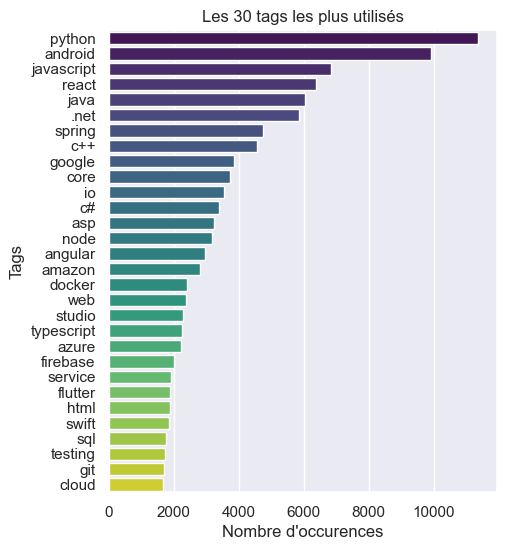

In [39]:
# Sélectionner les 30 premiers mots
top_30_tags = df_tags_corpus.head(30)

# Créer le diagramme en barres avec Seaborn
plt.figure(figsize=(5, 6))
sns.barplot(x='Nombre', y='Tags', data=top_30_tags, palette='viridis')
plt.xlabel("Nombre d'occurences")
plt.ylabel('Tags')
plt.title('Les 30 tags les plus utilisés')
plt.show()

In [40]:
# Afficher un describe
df_tags_corpus.describe()

,Nombre
count,10603.000000
mean,32.447798
std,249.127453
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,11364.000000


Pour les tags, nous allons procéder différemment, on va seulement garder les 20 tags les plus utilisés.

In [41]:
# Sélectionner les 20 tags les plus utilisés
top_20_tags = df_tags_corpus.head(20)

# Obtenir la liste des tags
list_top_tags = top_20_tags['Tags'].tolist()

## 6. Nettoyage des documents <a class="anchor" id="6"></a>

Maintenant que l'on a analysé la contenance de nos corpus. Nous allons pouvoir paramétrer notre fonction de nettoyage afin de pouvoir l'utiliser directement sur les documents.

### 6.1 Nettoyage de Title_Body <a class="anchor" id="6_1"></a>

In [42]:
df_questions['clean_title_body'] = df_questions['Title_Body'].mapply(process_text, 
                                                                     rejoin = False, 
                                                                     lemm_or_stemm ='lem', 
                                                                     words_to_remove = words_to_remove, 
                                                                     technical_terms = technical_terms, 
                                                                     min_len_word = 2, 
                                                                     force_is_alpha = True, 
                                                                     eng_words = eng_words)

  0%|                                                                                           | 0/72 [00:00<…

### 6.2 Nettoyage des Tags <a class="anchor" id="6_2"></a>

In [43]:
df_questions['clean_tags'] = df_questions['Tags'].mapply(process_text, 
                                                         rejoin = False, 
                                                         lemm_or_stemm ='lem', 
                                                         words_to_remove = None, 
                                                         technical_terms = technical_terms, 
                                                         min_len_word = 2, 
                                                         force_is_alpha = True, 
                                                         eng_words = list_top_tags)

  0%|                                                                                           | 0/72 [00:00<…

## 7. Analyse après nettoyage <a class="anchor" id="7"></a>

In [44]:
# Copie du DataFrame df_questions
df_cleaned = df_questions.copy()

### 7.1 Pour clean_title_body <a class="anchor" id="7_1"></a>

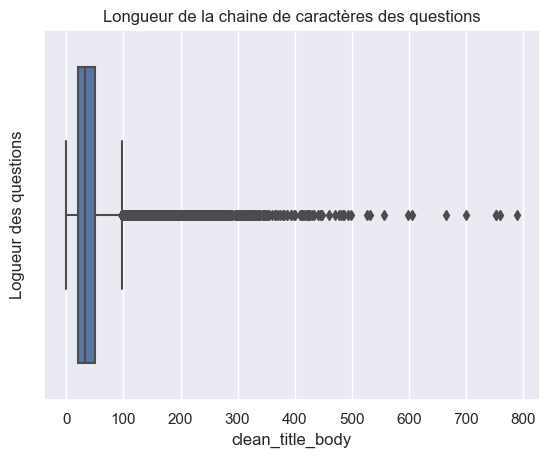

In [45]:
# Calculer la longeur des questions
len_questions_clean = df_cleaned['clean_title_body'].str.len()

# Rajouter un colonne dans le DataFrame
df_cleaned['_len_clean_title_body'] = len_questions_clean

# Affichons cela sur un graphique
plt.figure()
sns.boxplot(x = len_questions_clean)
plt.title('Longueur de la chaine de caractères des questions')
plt.ylabel('Logueur des questions')
plt.show()

In [46]:
# Affichons les  lignes où _len_clean_title_body = 0
df_cleaned.loc[df_cleaned['_len_clean_title_body'] == 0]

,Title,Body,Tags,CreationDate,Score,ViewCount,AnswerCount,_len_Title,_len_Questions,_len_Tags,Title_Body,clean_title_body,clean_tags,_len_clean_title_body
Id,,,,,,,,,,,,,,
54390275,ModuleNotFoundError: No module named 'Cython',<p>Why does <code>Cython</code> not want to wo...,<python><python-3.x><module><cython><python-im...,2019-01-27,17,30378,1,45,1231,51,ModuleNotFoundError: No module named 'Cython' ...,[],"[python, python, python]",0
58855820,"Using <style lang=""scss""> in vue component giv...",<p>I am trying to use vue js in rails.\nEveryt...,<ruby-on-rails><vue.js><webpack><sass><webpacker>,2019-11-14,8,16571,2,54,2074,49,Using,[],[],0
69366935,"Vue <script setup>, unable to use defineProps ...","<p>As per the <a href=""https://v3.vuejs.org/ap...",<vuejs3><vue-composition-api><vue-props><vue-s...,2021-09-28,10,13590,2,82,1584,67,Vue,[],[],0
69846842,How to vectorise int8 multiplcation in C (AVX2),<p>How do I vectorize this C function with AVX...,<c><x86><simd><intrinsics><avx2>,2021-11-04,6,517,2,47,222,32,How to vectorise int8 multiplcation in C (AVX2...,[],[],0
71495673,Vue 3 - How to add Polyfills to ChainWebpack,"<p>Using Vue 3, how do I add <code>path-browse...",<javascript><vue.js><webpack><babeljs><vuejs3>,2022-03-16,7,7349,2,44,837,46,Vue 3 - How to add Polyfills to ChainWebpack U...,[],[javascript],0


On va supprimer ces 5 questions qui après nettoyage ne contiennent plus aucun token.

In [47]:
# Supprimons la ligne
df_cleaned = df_cleaned.loc[df_cleaned['_len_clean_title_body'] != 0]

### 7.2 Pour clean_tags <a class="anchor" id="7_2"></a>

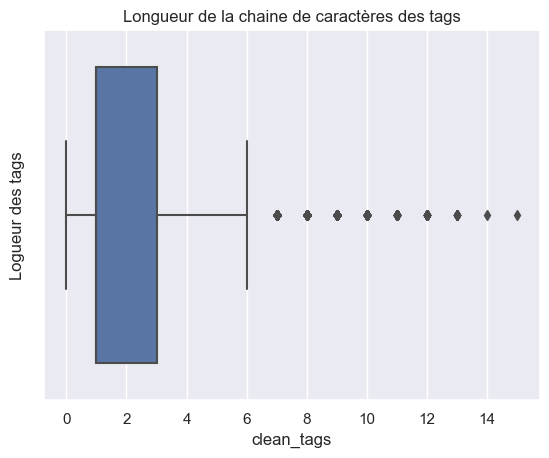

In [48]:
# Calculer la longeur des questions
len_tags_clean = df_cleaned['clean_tags'].str.len()

# Rajouter un colonne dans le DataFrame
df_cleaned['_len_clean_tags'] = len_tags_clean

# Affichons cela sur un graphique
plt.figure()
sns.boxplot(x = len_tags_clean)
plt.title('Longueur de la chaine de caractères des tags')
plt.ylabel('Logueur des tags')
plt.show()

In [49]:
# Affichons les  lignes où _len_clean_tags = 0
df_cleaned.loc[df_cleaned['_len_clean_tags'] == 0]

,Title,Body,Tags,CreationDate,Score,ViewCount,AnswerCount,_len_Title,_len_Questions,_len_Tags,Title_Body,clean_title_body,clean_tags,_len_clean_title_body,_len_clean_tags
Id,,,,,,,,,,,,,,,
45040070,JUnit4 and JUnit5 tests not running in IntelliJ,<p>I am trying to use JUnit4 and JUnit5 tests ...,<maven><intellij-idea><junit><junit4><junit5>,2017-07-11,12,16941,2,47,5621,45,JUnit4 and JUnit5 tests not running in Intelli...,"[test, test, test, based, added, dependency, p...",[],24,0
45041031,How many 1-byte NOPs can Skylake execute at on...,"<p>I'm aligning branch targets with NOPs, and ...",<assembly><optimization><x86><alignment><no-op>,2017-07-11,8,1538,3,53,691,47,How many 1-byte NOPs can Skylake execute at on...,"[many, execute, cycle, branch, target, sometim...",[],35,0
45041824,Account invoice report tax table,<p>i have costume model that add some fields t...,<html><css><odoo><odoo-9><qweb>,2017-07-11,6,765,1,32,4139,31,Account invoice report tax table i have costum...,"[account, invoice, report, tax, table, model, ...",[],43,0
45044691,How to serialize(JSON) FileField in Django,<p>I am new to Django and trying to build an a...,<json><django><serialization><django-forms><dj...,2017-07-11,11,12350,2,42,1583,57,How to serialize(JSON) FileField in Django I a...,"[serialize, json, django, django, thing, read,...",[],42,0
45045318,Efficient calculation of var-covar matrix in R,<p>I'm looking for efficiency gains in calcula...,<r><performance><statistics><data.table><panel...,2017-07-11,18,1283,2,46,1635,52,Efficient calculation of var-covar matrix in R...,"[efficient, calculation, matrix, looking, effi...",[],51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77330475,Remove only exact number of repeat matches bet...,<p>I want to get the remaining difference betw...,<bash><awk><grep><duplicates><compare>,2023-10-20,7,235,7,60,885,38,Remove only exact number of repeat matches bet...,"[remove, exact, number, repeat, match, file, d...",[],26,0
77350533,Can rust save the compiler's optimization record?,"<p>In C, I can output compiler optimization in...",<rust><llvm><inline><compiler-optimization><ru...,2023-10-24,6,163,1,49,626,55,Can rust save the compiler's optimization reco...,"[rust, save, compiler, optimization, record, c...",[],24,0
77481565,Replace whole column with a new value in all m...,<p>I have the following lines in a file</p>\n<...,<regex><linux><awk><replace><substr>,2023-11-14,6,143,4,59,1377,36,Replace whole column with a new value in all m...,"[replace, whole, column, multiple, line, line,...",[],46,0


On va donc supprimer les 9594  lignes pour lesquelles nous n'avons plus aucun tag.

In [50]:
# Supprimons les lignes
df_cleaned = df_cleaned.loc[df_cleaned['_len_clean_tags'] != 0]
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40401 entries, 45026159 to 77574918
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Title                  40401 non-null  object
 1   Body                   40401 non-null  object
 2   Tags                   40401 non-null  object
 3   CreationDate           40401 non-null  object
 4   Score                  40401 non-null  int64 
 5   ViewCount              40401 non-null  int64 
 6   AnswerCount            40401 non-null  int64 
 7   _len_Title             40401 non-null  int64 
 8   _len_Questions         40401 non-null  int64 
 9   _len_Tags              40401 non-null  int64 
 10  Title_Body             40401 non-null  object
 11  clean_title_body       40401 non-null  object
 12  clean_tags             40401 non-null  object
 13  _len_clean_title_body  40401 non-null  int64 
 14  _len_clean_tags        40401 non-null  int64 
dtypes: int64(8), o

## 8. Export du DataFrame nettoyé <a class="anchor" id="8"></a>

In [51]:
df_cleaned = df_cleaned[['clean_title_body', 'clean_tags']]
df_cleaned

,clean_title_body,clean_tags
Id,,
45026159,"[data, binding, adapter, android, populate, ha...","[android, android, android, android]"
45036635,"[thread, starvation, performance, testing, app...","[c#, .net]"
45037328,"[http, proxy, completely, ssl, connect, proxy,...",[python]
45037335,"[chart, chart, color, border, line, per, chart...","[javascript, react]"
45037547,"[logarithm, rust, java, rust, per, java, give,...",[java]
...,...,...
77544923,"[aggregate, column, list, intersection, elemen...","[python, python]"
77551316,"[char, literal, persistently, exist, long, pro...",[c++]
77556444,"[null, primary, constructor, c#, c#, c#, prima...","[c#, .net, c#]"


In [52]:
# Supprimer les doublons de la colonne 'clean_tags'
df_cleaned['clean_tags'] = df_cleaned['clean_tags'].apply(lambda x: list(set(x)))

# Appliquer une fonction lambda pour ne conserver que les deux premiers tags
df_cleaned['clean_tags'] = df_cleaned['clean_tags'].apply(lambda x: x[:2] if isinstance(x, list) else x)
df_cleaned

,clean_title_body,clean_tags
Id,,
45026159,"[data, binding, adapter, android, populate, ha...",[android]
45036635,"[thread, starvation, performance, testing, app...","[.net, c#]"
45037328,"[http, proxy, completely, ssl, connect, proxy,...",[python]
45037335,"[chart, chart, color, border, line, per, chart...","[react, javascript]"
45037547,"[logarithm, rust, java, rust, per, java, give,...",[java]
...,...,...
77544923,"[aggregate, column, list, intersection, elemen...",[python]
77551316,"[char, literal, persistently, exist, long, pro...",[c++]
77556444,"[null, primary, constructor, c#, c#, c#, prima...","[.net, c#]"


In [53]:
df_cleaned.to_csv('questions_cleaned.csv')

## 9. Enregistrement des listes pour l'API <a class="anchor" id="9"></a>

In [55]:
# Enregistrement des listes
with open('lists_data.pkl', 'wb') as fichier:
    pickle.dump({
        'technical_terms': technical_terms,
        'words_to_remove': words_to_remove,
        'eng_words': eng_words
    }, fichier)